# Principle modelling

## wavelength scale
$\lambda^\mathrm{r}=k_{\mathrm{\lambda\ m-c}}\bullet\left(\lambda_\mathrm{s}+\lambda_{\mathrm{a-c}}+\lambda_{\mathrm{a-uc}}+\lambda_{\mathrm{a-f}}\right)$

## value scale
$S^\mathrm{r}=S_\mathrm{s}\bullet k_{\mathrm{Sm-f}}\bullet k_{\mathrm{Sm-c}}\bullet\left(1+S_{\mathrm{a-c}}+S_{\mathrm{a-uc}}+S_{\mathrm{a-f}}\right)$



In [1]:
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity

#%run -i jhelp


import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from empir19nrm02.tools.help import plotCorrelation
from empir19nrm02.tools import plotHistScales, plotHistGauss, plot_2D
from empir19nrm02.MC import DistributionParam, MCVar, MCSimulation, NameUnit, MCVectorVar, pickle_copy, save_to_csv, save_to_excel, load_from_csv, load_from_excel, StatDataVector
from empir19nrm02 import _SPD, _RES
import pandas as pd
from empir19nrm02.tools import sumMC, sumMCV

import luxpy as lx
from luxpy import _CIE_ILLUMINANTS, _CMF

out_dir = 'MCSim_PM'

wl = lx.getwlr([360,830,5])
NumberTrials = 100000
# Number of base functions (as a hack with pos/neg number of base functions to select the type...)
# >0 use sin/cos base functions
# <0 use chebyshev base functions
N_Fourier = 'c 7 s'
maxOutElements = 5
lambda0 = 555

import os
print( 'CWD:', os.getcwd())

marker = ['-', '--', '-.',':', '.', 'o', '-', '--','-.',':','.']
point_marker = ['x', 'o', 'v', '^']
mColor = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'r', 'g', 'b', 'c']

CWD: E:\TTBV\Python\empir19nrm02\empir19nrm02\Jupyter


In [2]:
def get_min_max_median(f1p):
    print( 'Detector number:', len(f1p))
    iMin = np.argmin(f1p[1:])+1
    iMax = np.argmax(f1p)
    iMedian = np.argmin(np.abs(np.median(f1p) - f1p))
    print( 'Best detector: ', iMin, 'with $f_1^\prime$=', f1p[iMin])
    print( 'Worst detector: ', iMax, 'with $f_1^\prime$=', f1p[iMax])
    print( 'Median detector: ', iMedian, 'with $f_1^\prime$=', f1p[iMedian])
    return iMin, iMax, iMedian

YDetectors


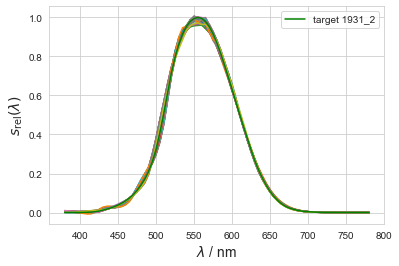

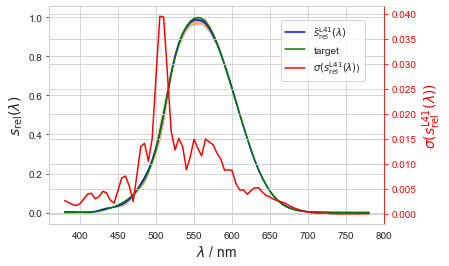

Detector number: 29
Best detector:  24 with $f_1^\prime$= 0.007411326248656909
Worst detector:  12 with $f_1^\prime$= 0.03682914965977278
Median detector:  20 with $f_1^\prime$= 0.023784259364672006


In [3]:
_name = 'YDetectors'
_detectors=_RES[_name]['S']['data'].copy()
YNorm, f1pY = display_responsivity(_name, _detectors, cieobs='1931_2', s_target_index=2, out_dir=out_dir, S_C='A')
iMin, iMax, iMedian = get_min_max_median( f1pY)

# 0 the ideal detector, otherwise a number from the database
iDetector = iMax
currentDetector = lx.cie_interp(_detectors, wl_new=wl, kind='S')[iDetector+1]
s_target = _CMF['1931_2']['bar'][[0,2]].copy()
s_target = lx.cie_interp(s_target, wl_new = wl, kind = 'S')[1]


# Make some very first MCS


In [4]:
# define some input data (as MCVar to make an analysis after the run)
T0 = 3000
mcT = MCVar(name=NameUnit('T', 'K'), distribution=DistributionParam(mean=T0,stddev=1., distribution='normal'))

# wavelength
mcLambda_a_c = MCVar(name=NameUnit('lambda_a_c', 'nm'), distribution=DistributionParam(mean=0.,stddev=1., distribution='normal'))

mcLambda_a_uc = MCVectorVar(name=NameUnit('lambda_a_uc', 'nm'), elements=len(wl))
mcLambda_a_uc.set_vector_param( np.zeros(len(wl)), np.ones(len(wl)))

mcLambda_a_f = MCVectorVar(name=NameUnit('lambda_a_f', 'nm'), elements=len(wl), noise_list={ 'f_add': DistributionParam(mean = 0, stddev = 1, distribution = 'normal', add_params = N_Fourier)})
mcLambda_a_f.set_vector_param( np.zeros(len(wl)), np.ones(len(wl)))

mcLambda_m_c = MCVar(name=NameUnit('lambda_m_c', 'nm'), distribution=DistributionParam(mean=1.,stddev=0.001, distribution='normal'))

# Signal
mcS_a_c = MCVar(name=NameUnit('S_a_c', ''), distribution=DistributionParam(mean=0.,stddev=0.01, distribution='normal'))

mcS_a_uc = MCVectorVar(name=NameUnit('S_a_uc', ''), elements=len(wl))
mcS_a_uc.set_vector_param( np.zeros(len(wl)), 0.01*np.ones(len(wl)))

mcS_a_f = MCVectorVar(name=NameUnit('S_a_f', ''), elements=len(wl), noise_list={ 'f_add': DistributionParam(mean = 0, stddev = 0.01, distribution = 'normal', add_params = N_Fourier)})
mcS_a_f.set_vector_param( np.zeros(len(wl)), 0.01*np.ones(len(wl)))

mcS_m_c = MCVar(name=NameUnit('S_m_c', ''), distribution=DistributionParam(mean=1.,stddev=0.01, distribution='normal'))

mcS_m_f = MCVectorVar(name=NameUnit('S_m_f', ''), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean = 0, stddev = 0.01, distribution = 'normal', add_params = N_Fourier)})
mcS_m_f.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))


# define some output data (as MCVar to make an analysis after the run)
mcYxy = MCVectorVar(name=NameUnit(['Y','x','y'], ['','','']), elements=3)
mcCCT = MCVar(name=NameUnit('CCT', 'K'))
mcDuv = MCVar(name=NameUnit('Duv', ''))
mcSMCF = MCVar(name=NameUnit('SMCF', ''))
mcSpectrum = MCVectorVar(name=NameUnit('L', ''), elements=len(wl))

# define some basic data needed inside the MCS
kBB = 1./(lx.spd_to_xyz(lx.blackbody(T0, wl, relative=False))[0][1])

# helpwise the delta lambda values for the integration
dl = lx.getwld(wl) # wavelength differences (unequal wavelength spacings are taken into account)
dl = dl*np.ones_like(wl) # ensure array like for matrix multiplication

# simple model calculating the photometric integral from the photometers
def model_L0( T, Lambda_a_c, Lambda_a_uc, Lambda_a_f, Lambda_m_c, S_a_c, S_a_uc, S_a_f, S_m_c, S_m_f):
    #wl_in = (1. + Lambda_a_c + Lambda_a_uc + Lambda_a_f)
    wl_mod = Lambda_m_c*(wl + Lambda_a_c + Lambda_a_uc + Lambda_a_f)
    # using the manipulated wl-scale for calculation of the bb
    bb = lx.blackbody(T, wl_mod, relative=False)
    # reconstruct the nominal one
    bb_mod = bb.copy()
    bb_mod[0] = wl
    bb_mod[1] *= kBB
    bb_mod[1] = bb_mod[1]*S_m_f*S_m_c*(1. + S_a_c + S_a_uc + S_a_f)
    XYZ = lx.spd_to_xyz(bb_mod, relative=False)
    Yxy = lx.xyz_to_Yxy(XYZ)
    CCT, duv = lx.xyz_to_cct(XYZ, out = 'cct,duv')
    SMCF = (bb_mod[1] @ (s_target*dl).T) / (bb_mod[1] @ (currentDetector*dl).T)

    return [Yxy[0], CCT, duv, SMCF, bb_mod[1]]

input = [mcT, mcLambda_a_c, mcLambda_a_uc, mcLambda_a_f, mcLambda_m_c, mcS_a_c, mcS_a_uc, mcS_a_f, mcS_m_c, mcS_m_f]
output = [mcYxy, mcCCT, mcDuv, mcSMCF, mcSpectrum]

# prepare and run the MCS
sim = MCSimulation(trials=NumberTrials)
# set the input and output data
sim.set_input_var(input)
sim.set_output_var(output)
# generate/load the random numbers
sim.generate()
# calculate the model
sim.calculate_model(model_L0)

res_data = sim.get_result_db()
res_data


Generate:


Input Unit         Mean   StdDev         Distr        Y     u(Y)  \
0            T    K 3,000.000000 1.000000        normal 1.000017 0.002806   
0   lambda_a_c   nm     0.000000 1.000000        normal 0.999980 0.006156   
0  lambda_a_uc   nm     0.000000 1.000000        normal 1.000001 0.001149   
0   lambda_a_f   nm     0.000000 1.000000  normal c 7 s 1.000001 0.000474   
0   lambda_m_c   nm     1.000000 0.001000        normal 1.000000 0.003454   
0        S_a_c          0.000000 0.010000        normal 1.000039 0.009996   
0       S_a_uc          0.000000 0.010000        normal 1.000000 0.001858   
0        S_a_f          0.000000 0.010000  normal c 7 s 1.000000 0.000649   
0        S_m_c          1.000000 0.010000        normal 0.999968 0.010016   
0        S_m_f          0.000000 0.010000  normal c 7 s 1.000010 0.000655   
0          All                                          1.000016 0.016279   

         x     u(x)        y     u(y)          CCT    u(CCT)       Duv  \
0 0.436937 0.000071 0.404074 0.000024 2,999.947367  0.996806 -0.000001   
0 0.436941 0.000573 0.404075 0.000245 2,999.913901  7.656195 -0.000001   
0 0.436935 0.000231 0.404072 0.000267 2,999.972181  3.961292 -0.000001   
0 0.436935 0.000393 0.404072 0.000139 2,999.976860  6.041046 -0.000001   
0 0.436938 0.000214 0.404074 0.000073 2,999.942035  3.007692 -0.000001   
0 0.436937 0.000000 0.404074 0.000000 2,999.942232  0.000460 -0.000001   
0 0.436937 0.000322 0.404074 0.000298 2,999.950235  6.417746 -0.000001   
0 0.436938 0.000573 0.404074 0.000136 2,999.963039 10.728178 -0.000000   
0 0.436937 0.000000 0.404074 0.000000 2,999.942235  0.000000 -0.000001   
0 0.436938 0.000577 0.404074 0.000137 2,999.963296 10.798767 -0.000000   
0 0.436936 0.001161 0.404071 0.000532 3,000.032882 19.821722 -0.000000   

    u(Duv)     SMCF  u(SMCF)  
0 0.000000 0.990268 0.000001  
0 0.000019 0.990268 0.000014  
0 0.000103 0.990268 0.000045  
0 0.000050 0.990268 0.000158  
0 0.000000 0.990268 0.000004  
0 0.000000 0.990268 0.000000  
0 0.000136 0.990268 0.000061  
0 0.000131 0.990268 0.000195  
0 0.000000 0.990268 0.000000  
0 0.000132 0.990268 0.000197  
0 0.000258 0.990268 0.000327

In [5]:
def get_name(i:int)->str:
    return res_data['Input'].values[i]

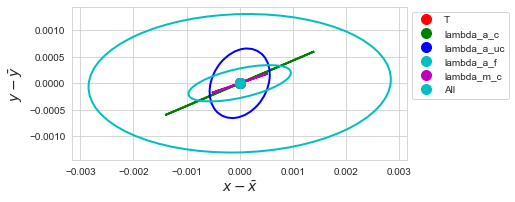

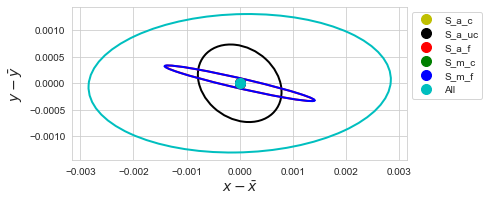

In [6]:
ax = None
len_part1 = 5
index_end = len(input)

for i in [*range(len_part1), index_end]:
    var = sim.output_var[i]
    ax = plot_2D(var[0], offset=1, center_data=True, marker_color=mColor[i], ax1=ax, name=get_name(i), number=0)

pyplot.legend(bbox_to_anchor=(1,1), loc="upper left")
save_fig(out_dir, 'xy_lambda_all')

ax = None
for i in range(len_part1, len(input)+1):
    var = sim.output_var[i]
    ax = plot_2D(var[0], offset=1, center_data=True, marker_color=mColor[i], ax1=ax, name=get_name(i), number=0)

pyplot.legend(bbox_to_anchor=(1,1), loc="upper left")
save_fig(out_dir, 'xy_S_all')

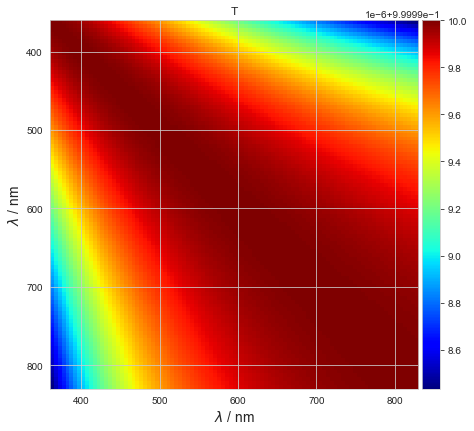

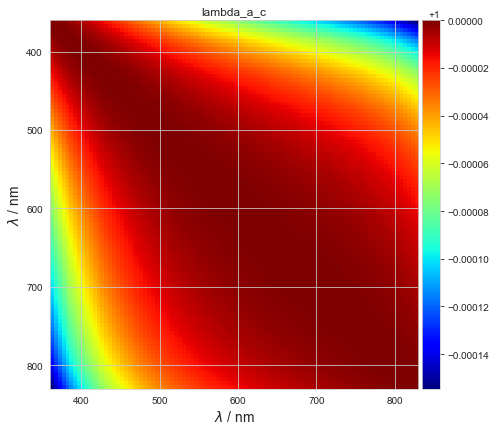

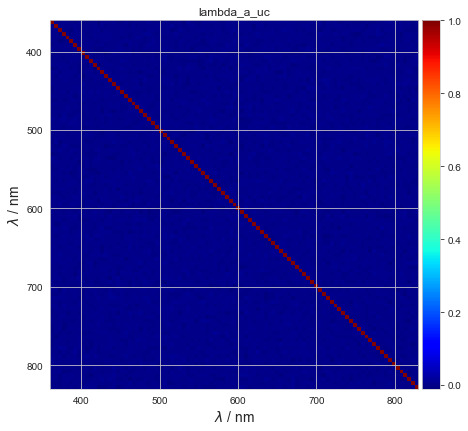

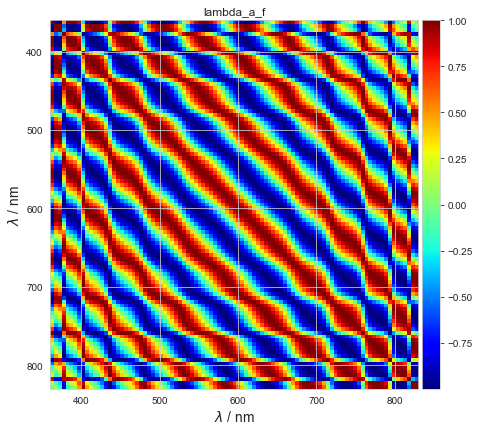

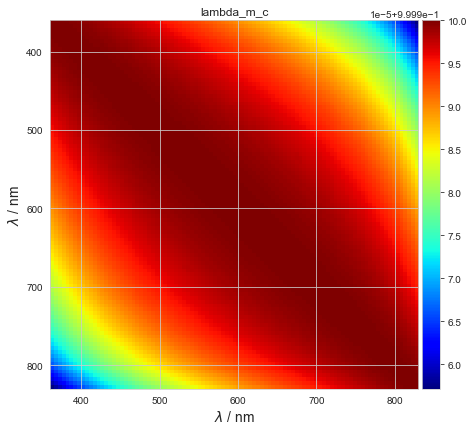

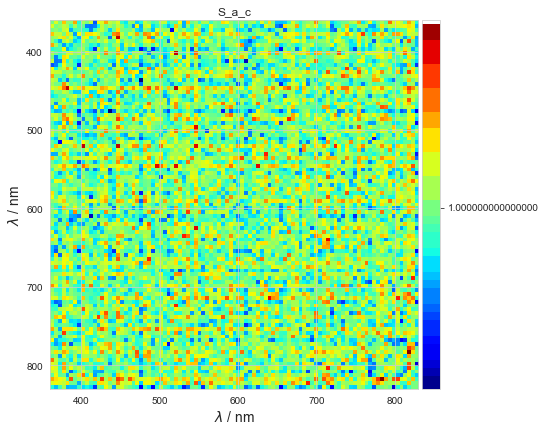

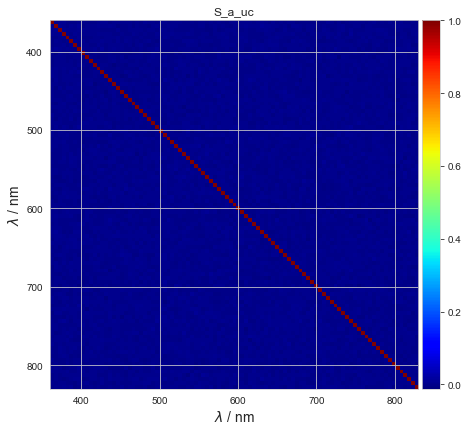

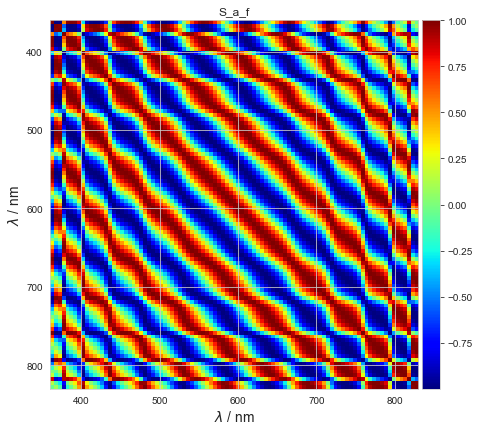

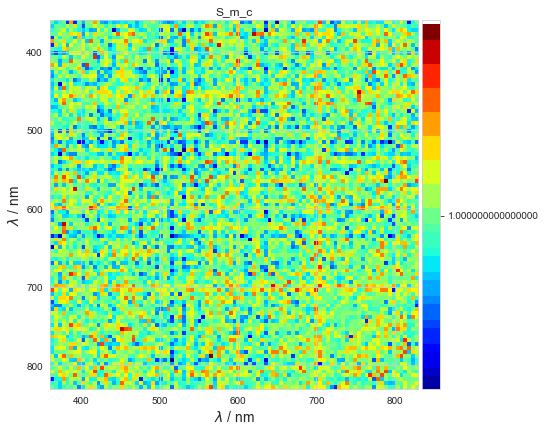

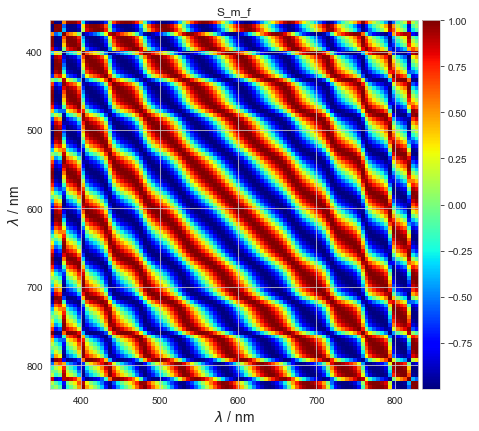

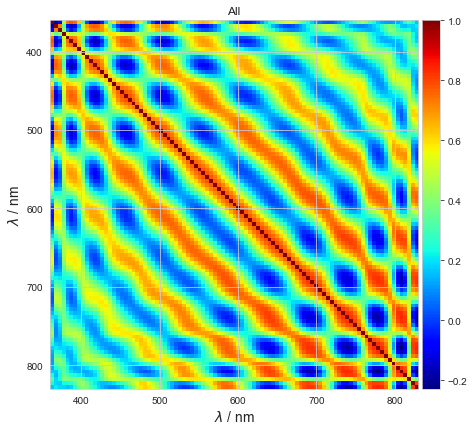

In [7]:
for i in range(len(input)+1):
    var = sim.output_var[i]
    var[-1].calc_cov_matrix_from_data()
    plotCorrelation(var[-1].runData.corr_matrix, wl, get_name(i))
    save_fig(out_dir, 'DataCorr_'+get_name(i))


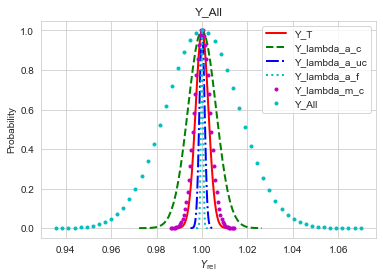

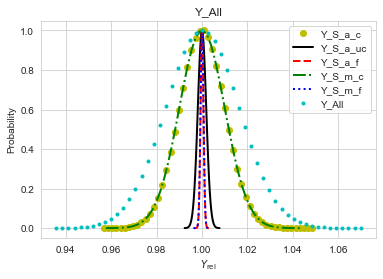

In [8]:
#display some histograms
ax1 = None
for i in [*range(len_part1), index_end]:
    var = sim.output_var[i]
    if ax1 is None:
        ax1 = plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title='Y_'+get_name(i), xLabel='$Y_{\mathrm{rel}}$', color=mColor[i]+marker[i], relative=True)
    else:
        plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title='Y_'+get_name(i), xLabel='$Y_{\mathrm{rel}}$', ax=ax1, color=mColor[i]+marker[i], relative=True)
save_fig(out_dir, 'HistYxy_Yrel_Lambda')

ax1 = None
for i in range(len_part1, index_end+1):
    var = sim.output_var[i]
    if ax1 is None:
        ax1 = plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title='Y_'+get_name(i), xLabel='$Y_{\mathrm{rel}}$', color=mColor[i]+marker[i], relative=True)
    else:
        plotHistGauss( var[0].val[:,0]/np.mean(var[0].val[:,0]), title='Y_'+get_name(i), xLabel='$Y_{\mathrm{rel}}$', ax=ax1, color=mColor[i]+marker[i], relative=True)
save_fig(out_dir, 'HistYxy_Yrel_S')


Value= [1.0000000000000002, 0.0028060486004902446] Inteval(95%)= 0.010999465419832766


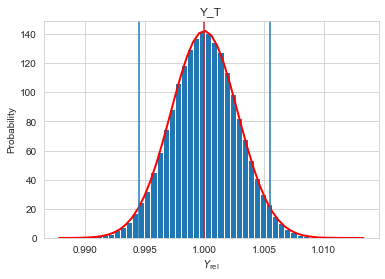

Value= [1.0, 0.006156359616331946] Inteval(95%)= 0.024250213806155996


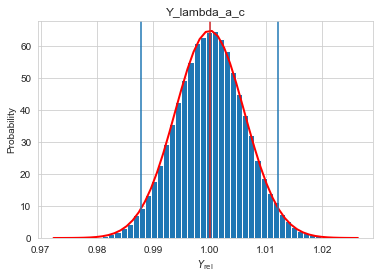

Value= [1.0, 0.0011493995521503777] Inteval(95%)= 0.004510849163231301


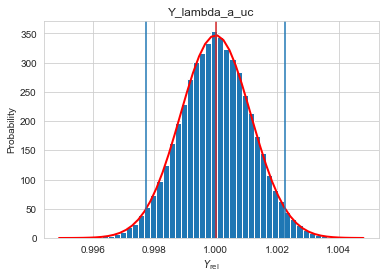

Value= [0.9999999999999999, 0.00047420775587257366] Inteval(95%)= 0.0020239150025148644


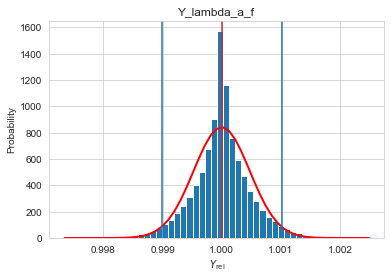

Value= [1.0000000000000002, 0.0034538838754979663] Inteval(95%)= 0.013518973623215191


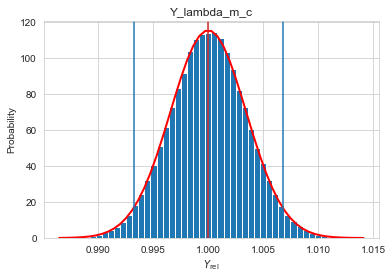

Value= [0.9999999999999999, 0.009995235577298625] Inteval(95%)= 0.03912596566200244


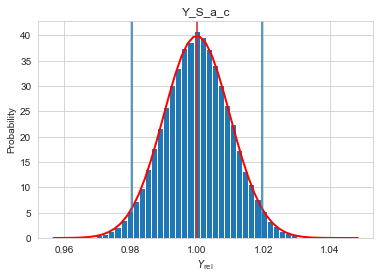

Value= [0.9999999999999999, 0.0018581722204224973] Inteval(95%)= 0.007266182024904255


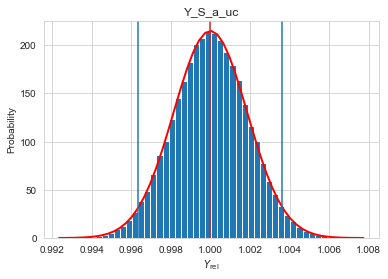

Value= [1.0000000000000002, 0.0006493814148580795] Inteval(95%)= 0.0027735976645804072


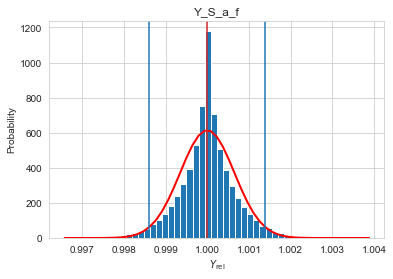

Value= [1.0000000000000002, 0.01001626374183282] Inteval(95%)= 0.03929899811112103


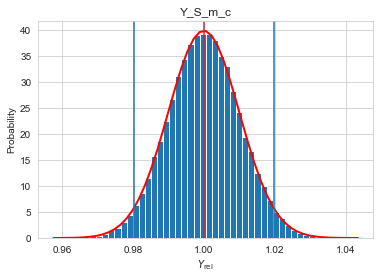

Value= [1.0, 0.0006554600119143887] Inteval(95%)= 0.0027949885921638717


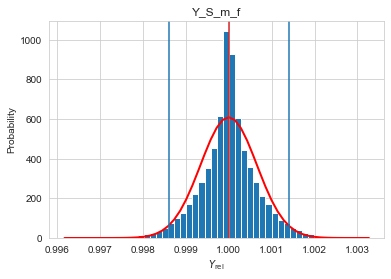

Value= [1.0, 0.016278974590594412] Inteval(95%)= 0.06381348033247303


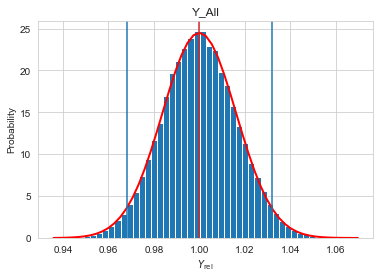

In [9]:
#display some histograms
for i in range(len(input)+1):
    var = sim.output_var[i]
    plotHistScales( var[0].val[:,0]/np.mean(var[0].val[:,0]), add_distribution=True, title='Y_'+get_name(i), xLabel='$Y_{\mathrm{rel}}$')
    save_fig(out_dir, 'HistYxy_Yrel_'+get_name(i))

In [10]:
var = sim.output_var[0]
column_str_MC= [var[0].name.get_name_unit(0)[0], var[0].name.get_name_unit(1)[0], var[0].name.get_name_unit(2)[0],
                var[1].name.get_name_unit()[0], var[2].name.get_name_unit()[0],var[3].name.get_name_unit()[0]]
for i in range(len(input)+1):
    var = sim.output_var[i]
    cct = sim.output_var[i][1]
    duv = sim.output_var[i][2]
    smcf = sim.output_var[i][3]
    print('Input_Var:', get_name(i))
    norm_data = pd.concat([pd.DataFrame(var[0].val[:,0]/np.mean(var[0].val[:,0])), pd.DataFrame(var[0].val[:,1]), pd.DataFrame(var[0].val[:,2]), pd.DataFrame(cct.val), pd.DataFrame(duv.val), pd.DataFrame(smcf.val)], axis=1)
    norm_data.columns = column_str_MC
    print( norm_data.corr())

Input_Var: T
             Y         x         y       CCT       Duv      SMCF
Y     1.000000 -0.999998 -0.999999  0.999999 -0.989396 -1.000000
x    -0.999998  1.000000  1.000000 -1.000000  0.989665  0.999999
y    -0.999999  1.000000  1.000000 -1.000000  0.989559  1.000000
CCT   0.999999 -1.000000 -1.000000  1.000000 -0.989617 -1.000000
Duv  -0.989396  0.989665  0.989559 -0.989617  1.000000  0.989518
SMCF -1.000000  0.999999  1.000000 -1.000000  0.989518  1.000000
Input_Var: lambda_a_c
             Y         x         y       CCT       Duv      SMCF
Y     1.000000 -0.999994 -0.999999  1.000000 -0.999999 -0.999999
x    -0.999994  1.000000  0.999989 -0.999996  0.999998  0.999987
y    -0.999999  0.999989  1.000000 -0.999998  0.999996  1.000000
CCT   1.000000 -0.999996 -0.999998  1.000000 -0.999999 -0.999998
Duv  -0.999999  0.999998  0.999996 -0.999999  1.000000  0.999995
SMCF -0.999999  0.999987  1.000000 -0.999998  0.999995  1.000000
Input_Var: lambda_a_uc
             Y         x        

In [11]:
import seaborn as sns
def get_data_step(size_to_minimize, max_data_to_display=1000):
    if size_to_minimize < max_data_to_display:
        step = 1
        disp_count = size_to_minimize
    else:
        step = int(size_to_minimize / max_data_to_display)
        disp_count = int(size_to_minimize / step)
    return disp_count, step


In [12]:
def seaborn_plot_result_gen(loc_result, display = [1,0,0], dim=3, column_str = [], title=''):
    disp_array_count, step = get_data_step(loc_result.shape[1])
    disp_array = np.zeros((dim, disp_array_count - 1))
    print( loc_result[:,0])
    for i in range(disp_array_count - 1):
        for j in range(dim):
            match display[j]:
                case 0 | 'n' | 'none':   disp_array[j, i] = loc_result[j, i * step + 1]
                case 1 | 'r' | 'rel':    disp_array[j, i] = loc_result[j, i * step + 1] / loc_result[j, 0]
                case 2 | 'd' | 'diff':   disp_array[j, i] = loc_result[j, i * step + 1] - loc_result[j, 0]
                case _: print('Display kind', display[j], ' not supported')

    sns.set_theme(style="ticks")
    column_str_loc = column_str.copy()
    for j in range(dim):
        match display[j]:
            case 0 | 'n' | 'none':   column_str_loc[j] = '$'+ column_str_loc[j] + '$'
            case 1 | 'r' | 'rel':    column_str_loc[j] = '$'+ column_str_loc[j] + '_{\mathrm{rel}}$'
            case 2 | 'd' | 'diff':   column_str_loc[j] = '$'+ '\Delta ' + column_str_loc[j] + '$'
            case _: print('Display kind', display[j], ' not supported')

    df = pd.DataFrame(data=disp_array.T, columns=column_str_loc)
    grid = sns.pairplot(df, corner=True)
    plotTitle = title

    grid.fig.suptitle(plotTitle.format())

Input_Var: T
[1.0000e+00 4.3694e-01 4.0407e-01 2.9999e+03 -7.9006e-07 9.9027e-01]


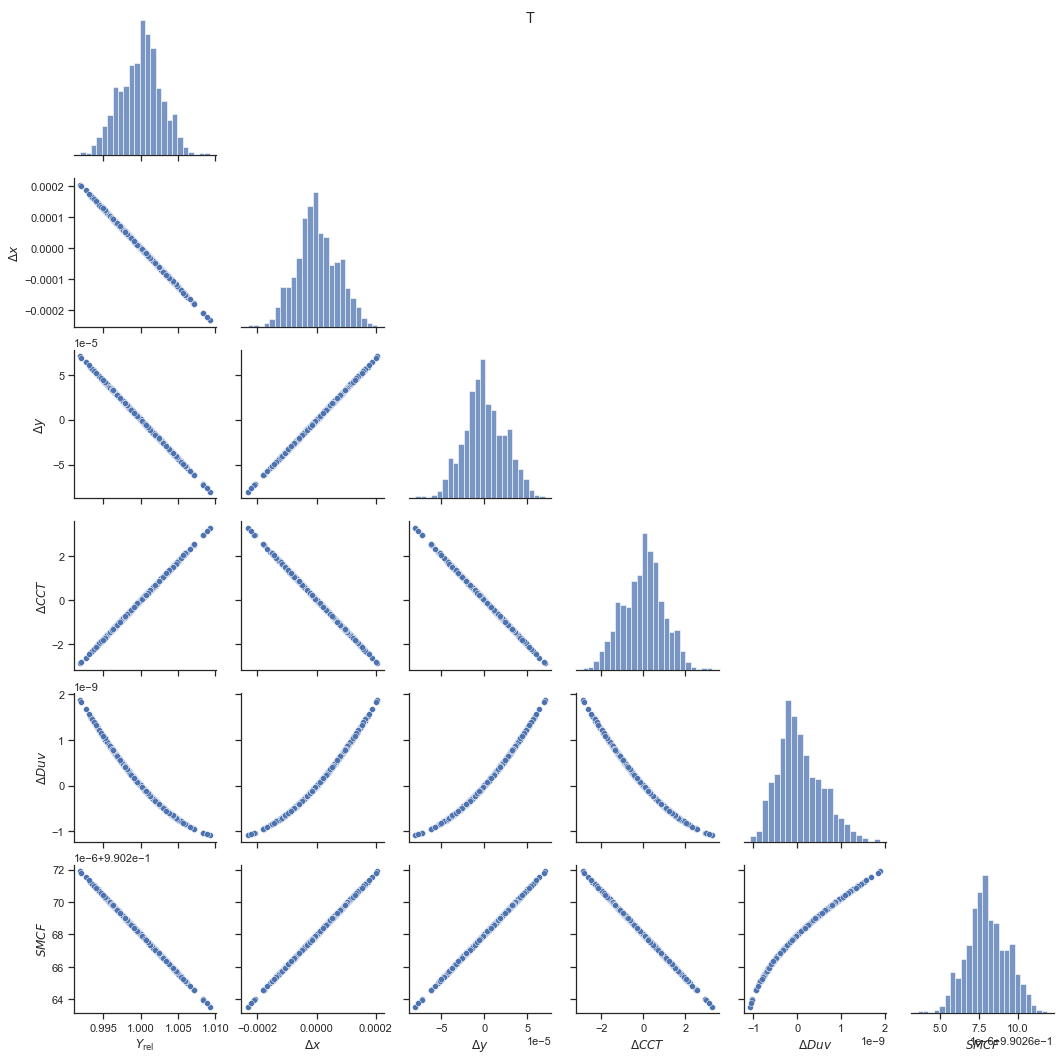

Input_Var: lambda_a_c
[1.0000e+00 4.3694e-01 4.0407e-01 2.9999e+03 -7.9006e-07 9.9027e-01]


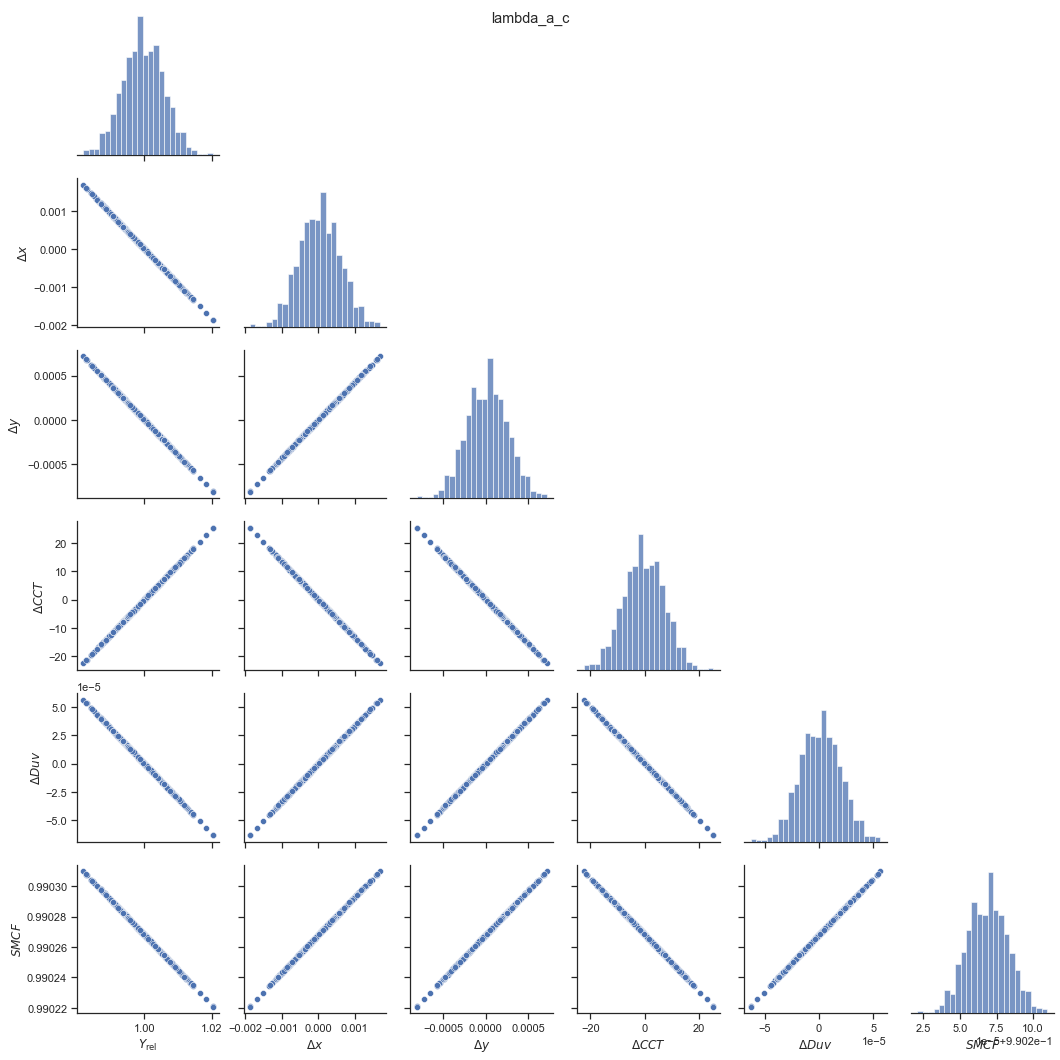

Input_Var: lambda_a_uc
[1.0000e+00 4.3694e-01 4.0407e-01 2.9999e+03 -7.9006e-07 9.9027e-01]


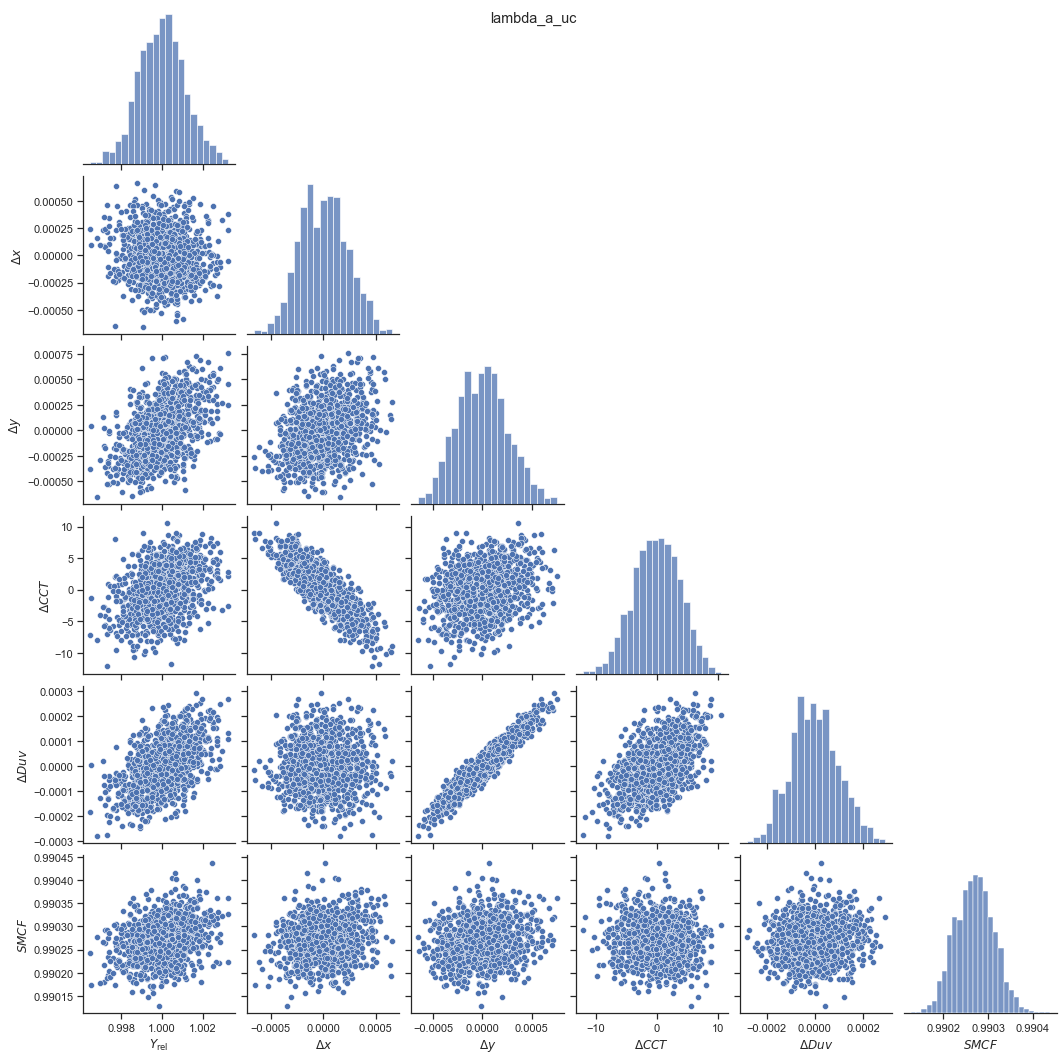

Input_Var: lambda_a_f
[1.0000e+00 4.3694e-01 4.0407e-01 2.9999e+03 -7.9006e-07 9.9027e-01]


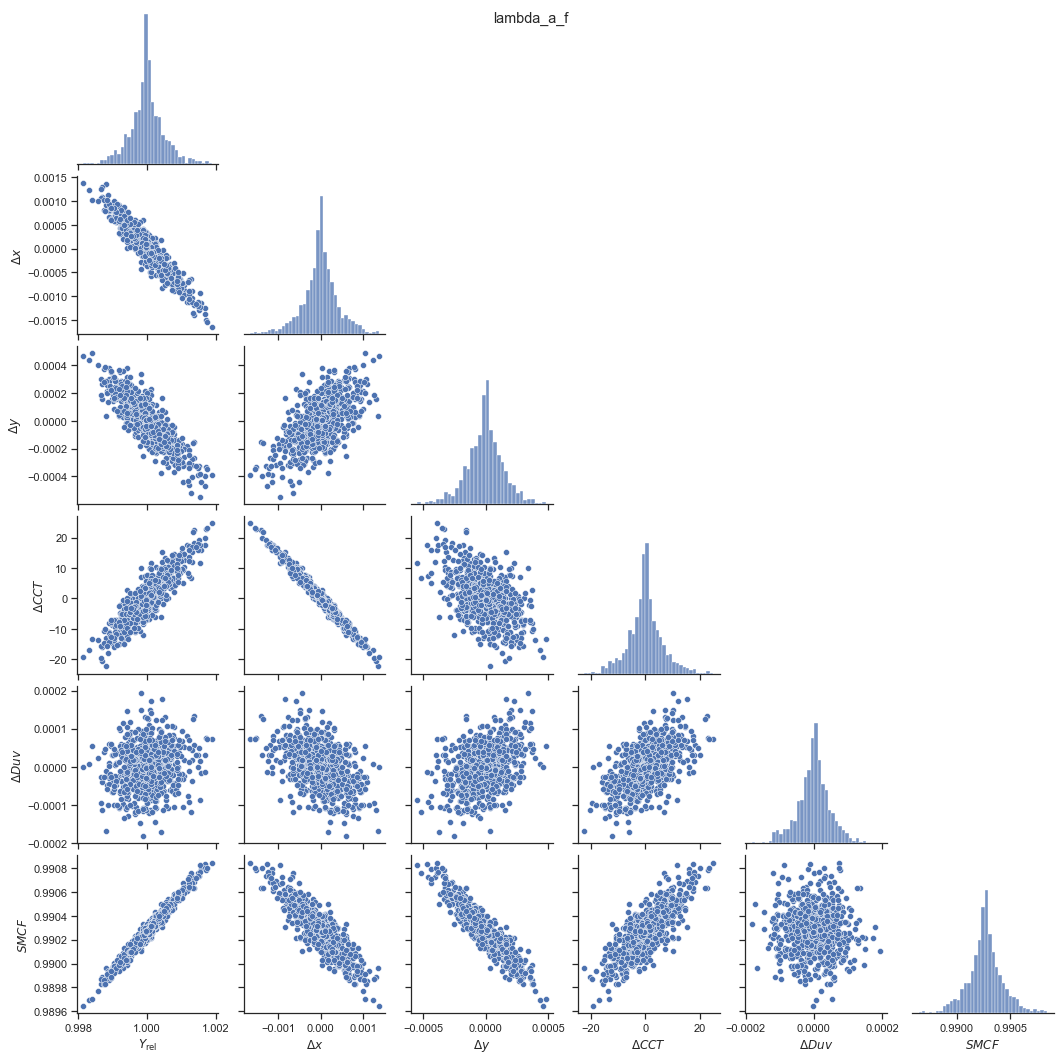

Input_Var: lambda_m_c
[1.0000e+00 4.3694e-01 4.0407e-01 2.9999e+03 -7.9006e-07 9.9027e-01]


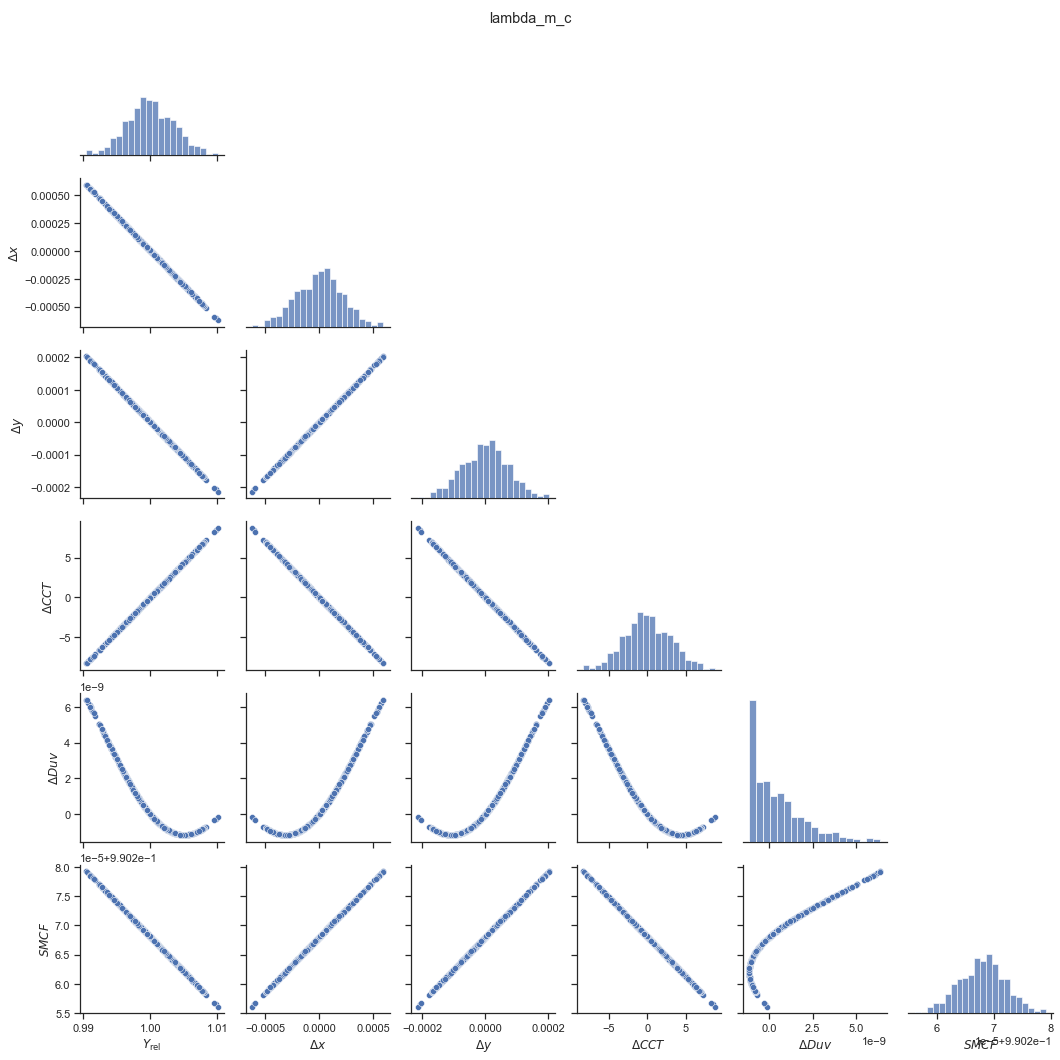

Input_Var: S_a_c
[1.0000e+00 4.3694e-01 4.0407e-01 2.9999e+03 -7.9006e-07 9.9027e-01]


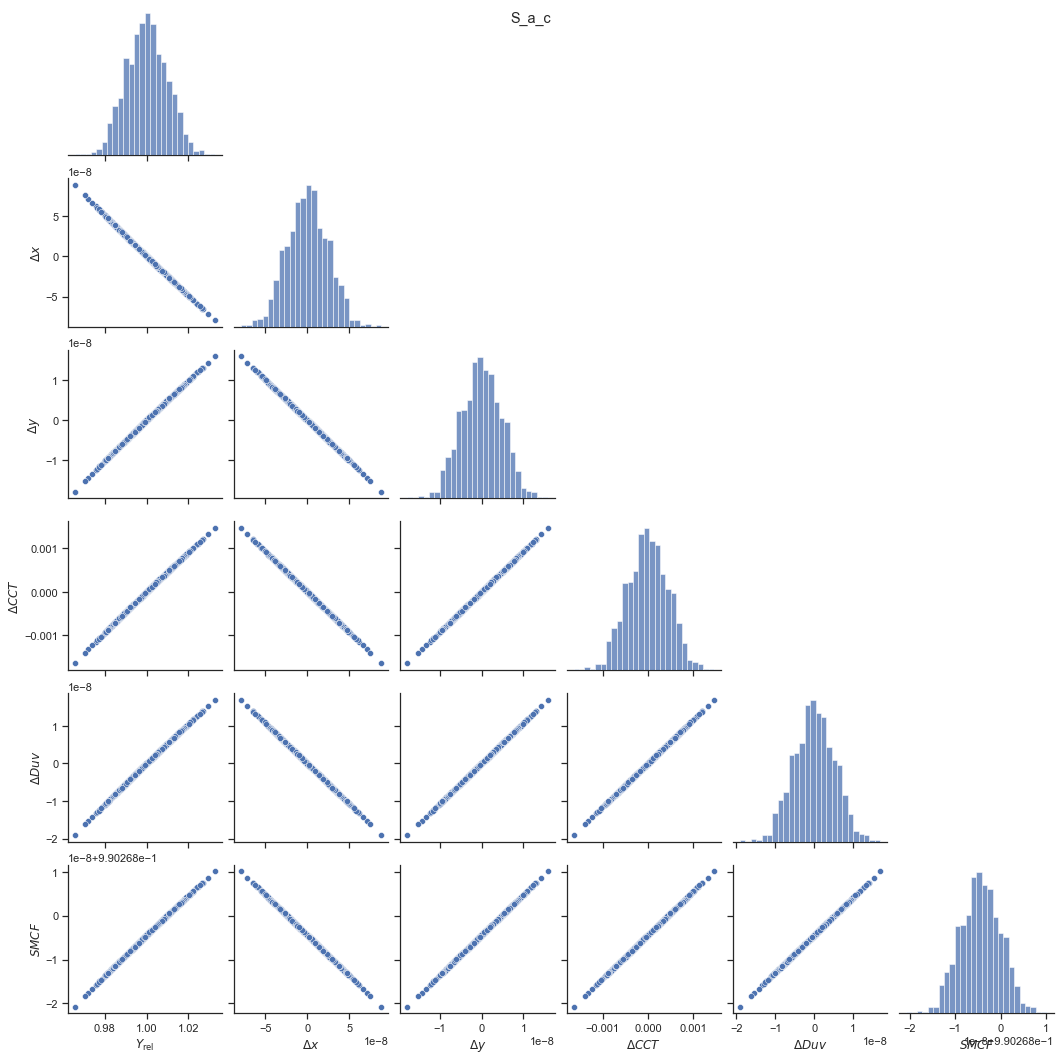

Input_Var: S_a_uc
[1.0000e+00 4.3694e-01 4.0407e-01 2.9999e+03 -7.9006e-07 9.9027e-01]


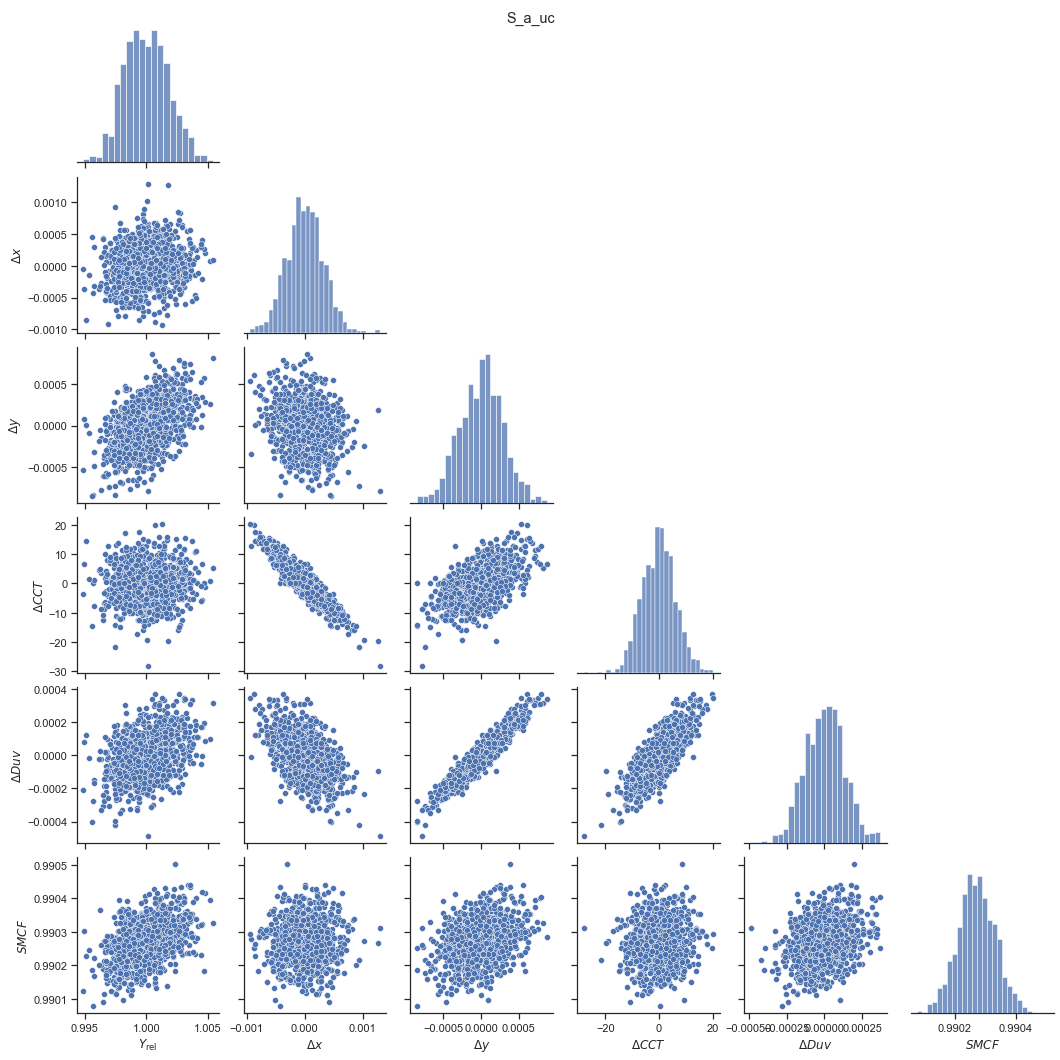

Input_Var: S_a_f
[1.0000e+00 4.3694e-01 4.0407e-01 2.9999e+03 -7.9006e-07 9.9027e-01]


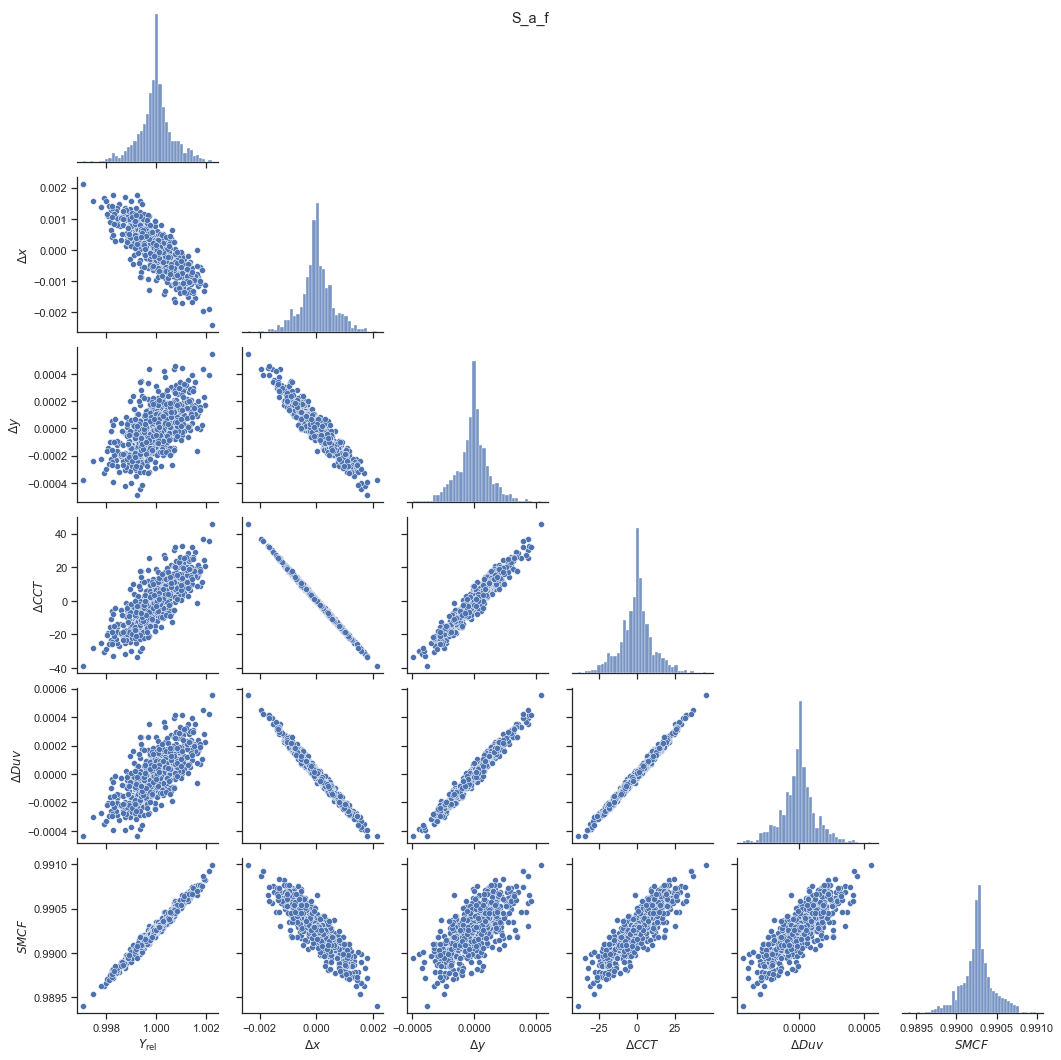

Input_Var: S_m_c
[1.0000e+00 4.3694e-01 4.0407e-01 2.9999e+03 -7.9006e-07 9.9027e-01]


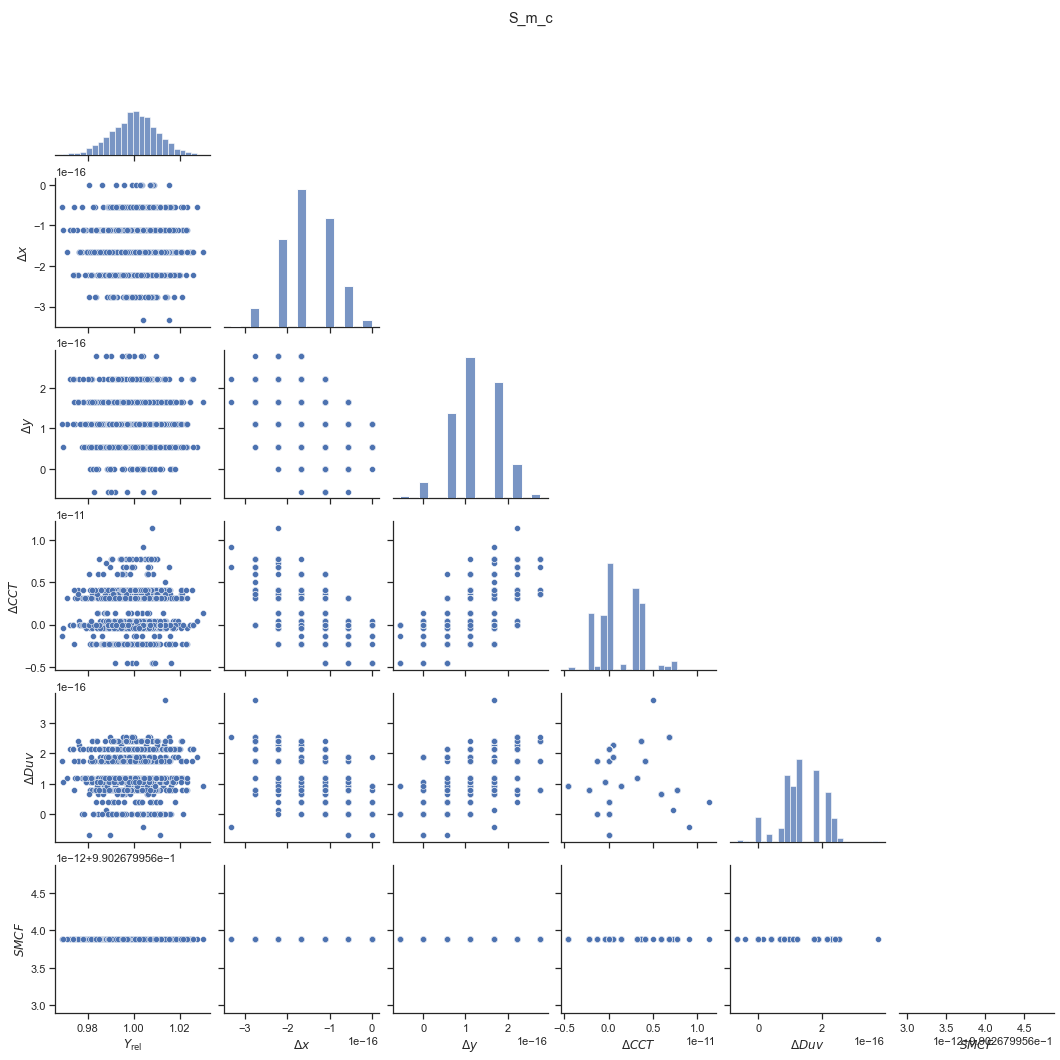

Input_Var: S_m_f
[1.0000e+00 4.3694e-01 4.0407e-01 2.9999e+03 -7.9006e-07 9.9027e-01]


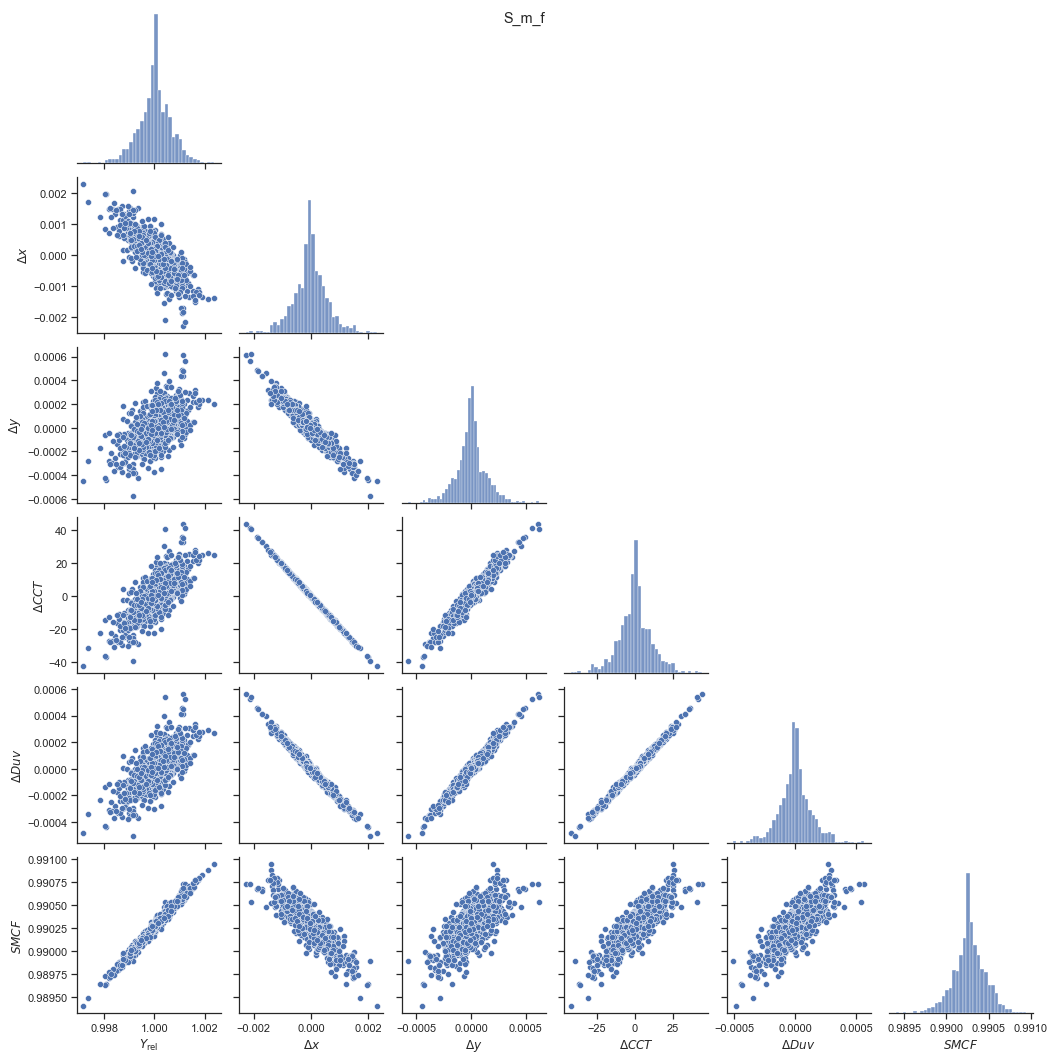

Input_Var: All
[1.0000e+00 4.3694e-01 4.0407e-01 2.9999e+03 -7.9006e-07 9.9027e-01]


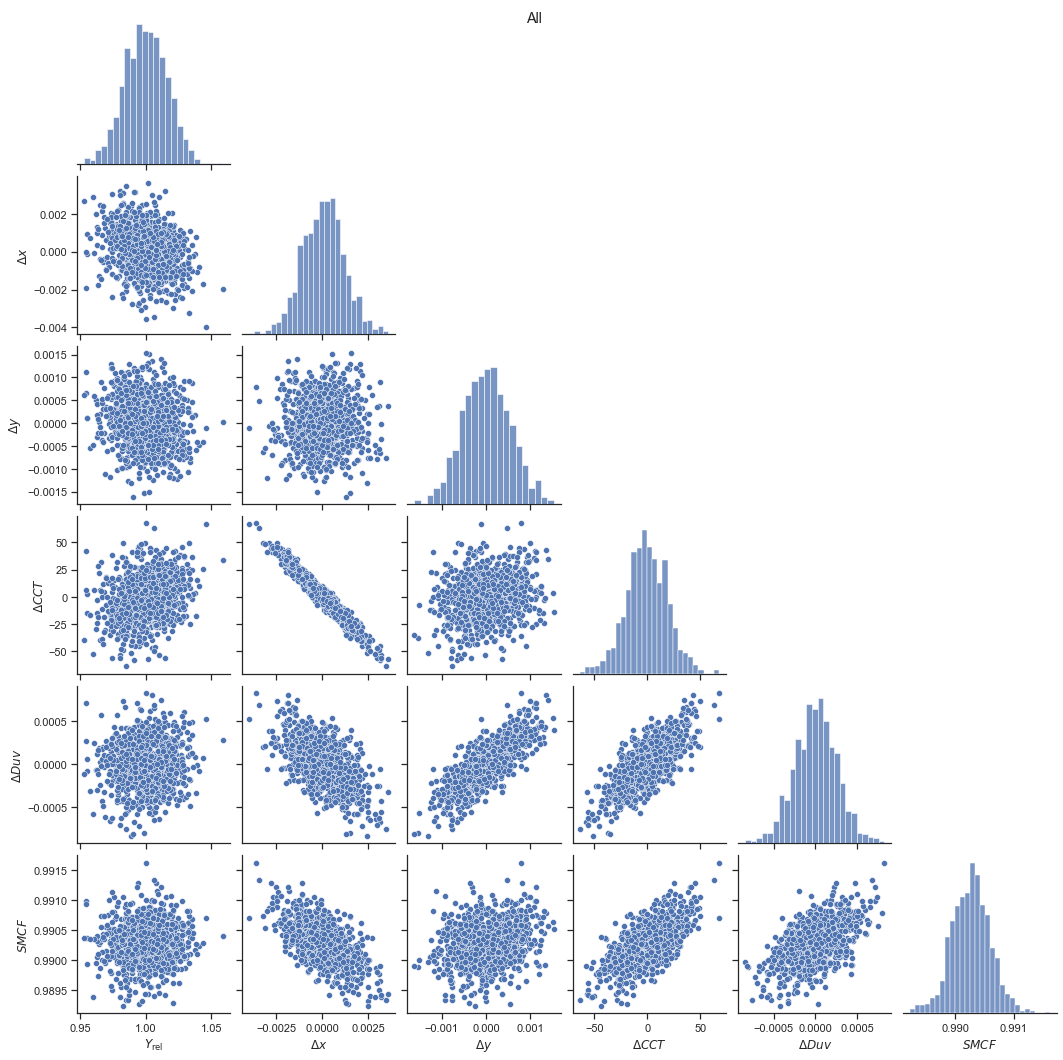

In [13]:
for i in range(len(input)+1):
    var = sim.output_var[i]
    cct = sim.output_var[i][1]
    duv = sim.output_var[i][2]
    smcf = sim.output_var[i][3]
    print('Input_Var:', get_name(i))
    seaborn_plot_result_gen(np.vstack((var[0].val.T, cct.val.T, duv.val.T, smcf.val.T)), display=['r','d','d','d','d','n'], dim=6, column_str=column_str_MC, title=get_name(i))
    save_fig(out_dir, 'Observation_YxyCCTDuv_' + get_name(i))

## A photometer measures the spectral distribution of a FEL lamp
## photometer and FEL described by correlation/covariance matrix
## without modeling the wavelength scale separately at the moment

65429.71085762574
f1prime= [3.2580e-02]
Generate:


Input Unit     Mean   StdDev   Distr        Y     u(Y)  \
0  PTBResFEL-1000W-Lamp-1      0.050024 0.000228  normal 1.000000 0.004579   
0    Add_PTBResPhot1.xlsx      0.000003 0.000000  normal 1.000000 0.000000   
0                     All                                1.000000 0.004579   

         x     u(x)        y     u(y)          CCT   u(CCT)      Duv   u(Duv)  \
0 0.431794 0.000161 0.402751 0.000098 3,077.688202 2.966204 0.000206 0.000047   
0 0.431793 0.000000 0.402751 0.000000 3,077.694153 0.000000 0.000206 0.000000   
0 0.431794 0.000161 0.402751 0.000098 3,077.688202 2.966204 0.000206 0.000047   

      SMCF  u(SMCF)      f1p   u(f1p)  
0 1.001900 0.000021 0.032580 0.000000  
0 1.001901 0.000471 0.032580 0.000060  
0 1.001901 0.000472 0.032580 0.000060

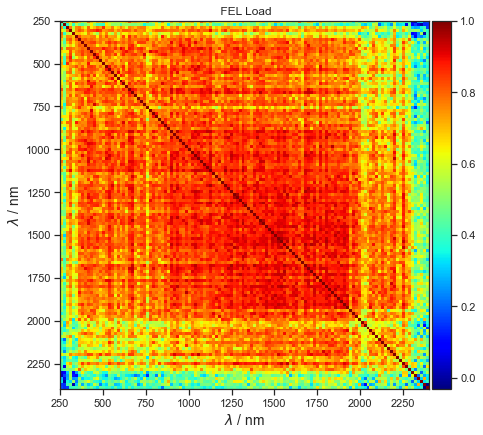

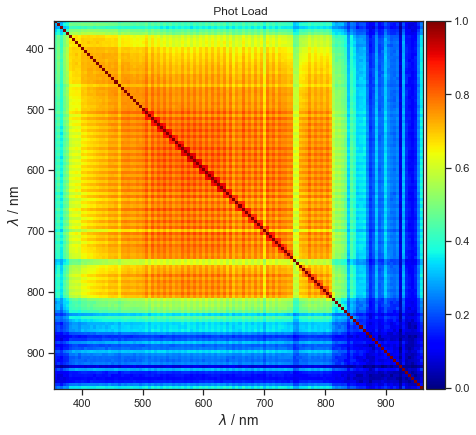

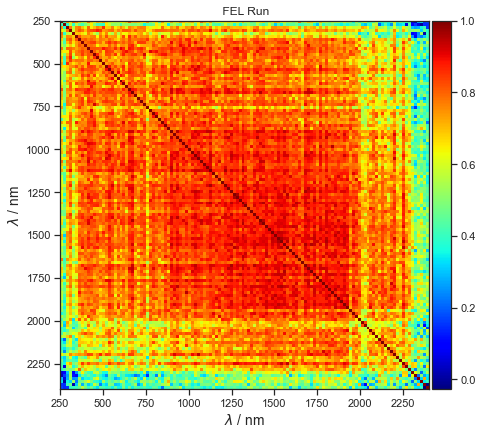

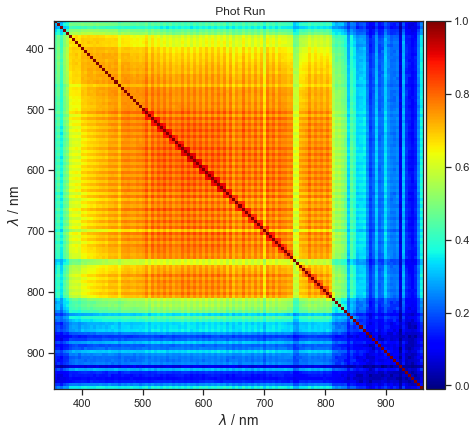

In [14]:
from empir19nrm02.spectral.spectral_data import _CORR_PATH

str_file = 'PTBResFEL-1000W-Lamp-1'
wlFEL, mcVectorVarFEL = load_from_csv(_CORR_PATH + '/' + str_file)
mcVectorVarFEL.name = NameUnit(str_file, '')
plotCorrelation(mcVectorVarFEL.setData.corr_matrix, wlFEL, ' FEL Load')

str_file_phot = 'Add_PTBResPhot1.xlsx'
wlPhot, mcVectorVarPhot = load_from_excel(_CORR_PATH + '/' + str_file_phot, wlColumn = 1, valColumn=2, stdColumn = 3, covColumn=None, corrColumn = 4, startRow=2)
mcVectorVarPhot.name = NameUnit(str_file_phot, '')
plotCorrelation(mcVectorVarPhot.setData.corr_matrix, wlPhot, ' Phot Load')

XYZ = lx.spd_to_xyz(np.vstack((wlFEL, mcVectorVarFEL.setData.v_mean)),relative=False)
kFEL = 1./(XYZ[0][1])

# helpwise the delta lambda values for the integration
dl = lx.getwld(wl) # wavelength differences (unequal wavelength spacings are taken into account)
dl = dl*np.ones_like(wl) # ensure array like for matrix multiplication

# calculate a 'calibration' factor here only to get a proper dimension of the result
fel_i = lx.cie_interp(np.vstack((wlFEL,mcVectorVarFEL.setData.v_mean)), wl_new = wl, kind='S')
phot_i = lx.cie_interp(np.vstack((wlPhot,mcVectorVarPhot.setData.v_mean)), wl_new = wl, kind='S')
bb_i = lx.blackbody(2856, wl3 = wl)
k1 = (bb_i[1] @ (phot_i[1]*dl).T)
k2 = (bb_i[1] @ (s_target*dl).T)
kPhot = k2/k1
print( kPhot)

print( 'f1prime=', lx.spectral_mismatch_and_uncertainty.f1prime(np.vstack((wlPhot,mcVectorVarPhot.setData.v_mean)), S_C='A', cieobs='1931_2', s_target_index=2))

# define some output data (as MCVar to make an analysis after the run)
mcYxy = MCVectorVar(name=NameUnit(['Y','x','y'], ['','','']), elements=3)
mcCCT = MCVar(name=NameUnit('CCT', 'K'))
mcDuv = MCVar(name=NameUnit('Duv', ''))
mcSMCF = MCVar(name=NameUnit('SMCF', ''))
mcf1p = MCVar(name=NameUnit('f1p', ''))
mcSpectrum = MCVectorVar(name=NameUnit('L', ''), elements=len(wlFEL))

# define some basic data needed inside the MCS

# simple model calculating the photometric integral from the photometers
def model_LFEL( FEL, Phot):
    # convert photometer responsivity and sd of the fel into the right wavelength scale
    fel = np.vstack((wlFEL, kFEL*FEL))
    fel_i = lx.cie_interp(fel, wl_new = wl, kind='S')
    phot = np.vstack((wlPhot, Phot))
    phot_i = lx.cie_interp(phot, wl_new = wl, kind='S')

    # calculate all required integral values for the output
    XYZ = lx.spd_to_xyz(fel, relative=False)
    Yxy = lx.xyz_to_Yxy(XYZ)
    CCT, duv = lx.xyz_to_cct(XYZ, out = 'cct,duv')
    SMCF = (fel_i[1] @ (s_target*dl).T) / (fel_i[1] @ (kPhot*phot_i[1]*dl).T)
    f1p = lx.spectral_mismatch_and_uncertainty.f1prime(np.vstack((wlPhot,Phot)), S_C='A', cieobs='1931_2', s_target_index=2)
    return [Yxy[0], CCT, duv, SMCF, f1p, fel[1]]

input = [mcVectorVarFEL, mcVectorVarPhot]
output = [mcYxy, mcCCT, mcDuv, mcSMCF, mcf1p, mcSpectrum]

# prepare and run the MCS
sim = MCSimulation(trials=NumberTrials)
# set the input and output data
sim.set_input_var(input)
sim.set_output_var(output)
# generate/load the random numbers
sim.generate()
# calculate the model
sim.calculate_model(model_LFEL)

res_data = sim.get_result_db()


mcVectorVarFEL.calc_cov_matrix_from_data()
plotCorrelation(mcVectorVarFEL.runData.corr_matrix, wlFEL, ' FEL Run')

mcVectorVarPhot.calc_cov_matrix_from_data()
plotCorrelation(mcVectorVarPhot.runData.corr_matrix, wlPhot, ' Phot Run')

res_data

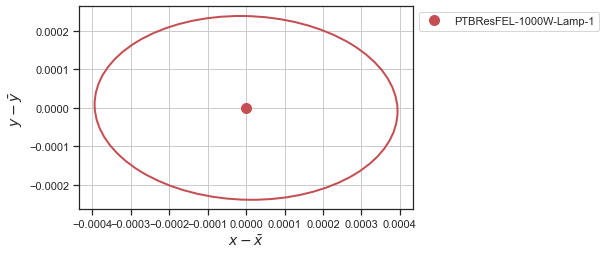

In [15]:
ax = None
for i in range(1):
    var = sim.output_var[i]
    ax = plot_2D(var[0], offset=1, center_data=True, marker_color=mColor[i], ax1=ax, name=get_name(i), number=0)

pyplot.legend(bbox_to_anchor=(1,1), loc="upper left")
save_fig(out_dir, 'xy_fel_all')

Value= [1.0, 0.004579414940368612] Inteval(95%)= 0.017928841546472896


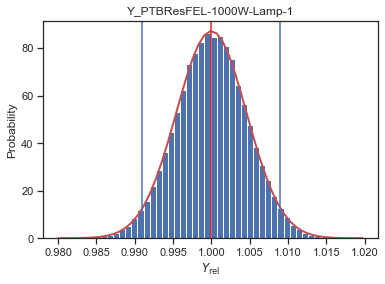

Value= [1.0, 0.0] Inteval(95%)= 0.0


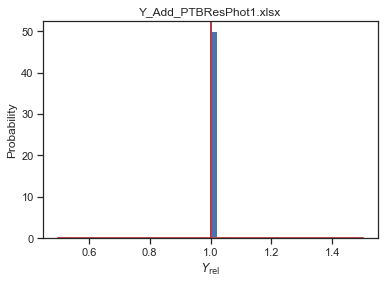

In [16]:
#display some histograms
for i in range(len(input)):
    var = sim.output_var[i]
    plotHistScales( var[0].val[:,0]/np.mean(var[0].val[:,0]), add_distribution=True, title='Y_'+get_name(i), xLabel='$Y_{\mathrm{rel}}$')
    save_fig(out_dir, 'HistYxy_Yrel_'+get_name(i))

In [17]:
#column_str_MC.pop()
column_str_MC.append('f_{1}^{´}')

Input_Var: PTBResFEL-1000W-Lamp-1
[1.0000e+00 4.3179e-01 4.0275e-01 3.0777e+03 2.0551e-04 1.0019e+00
 3.2580e-02]


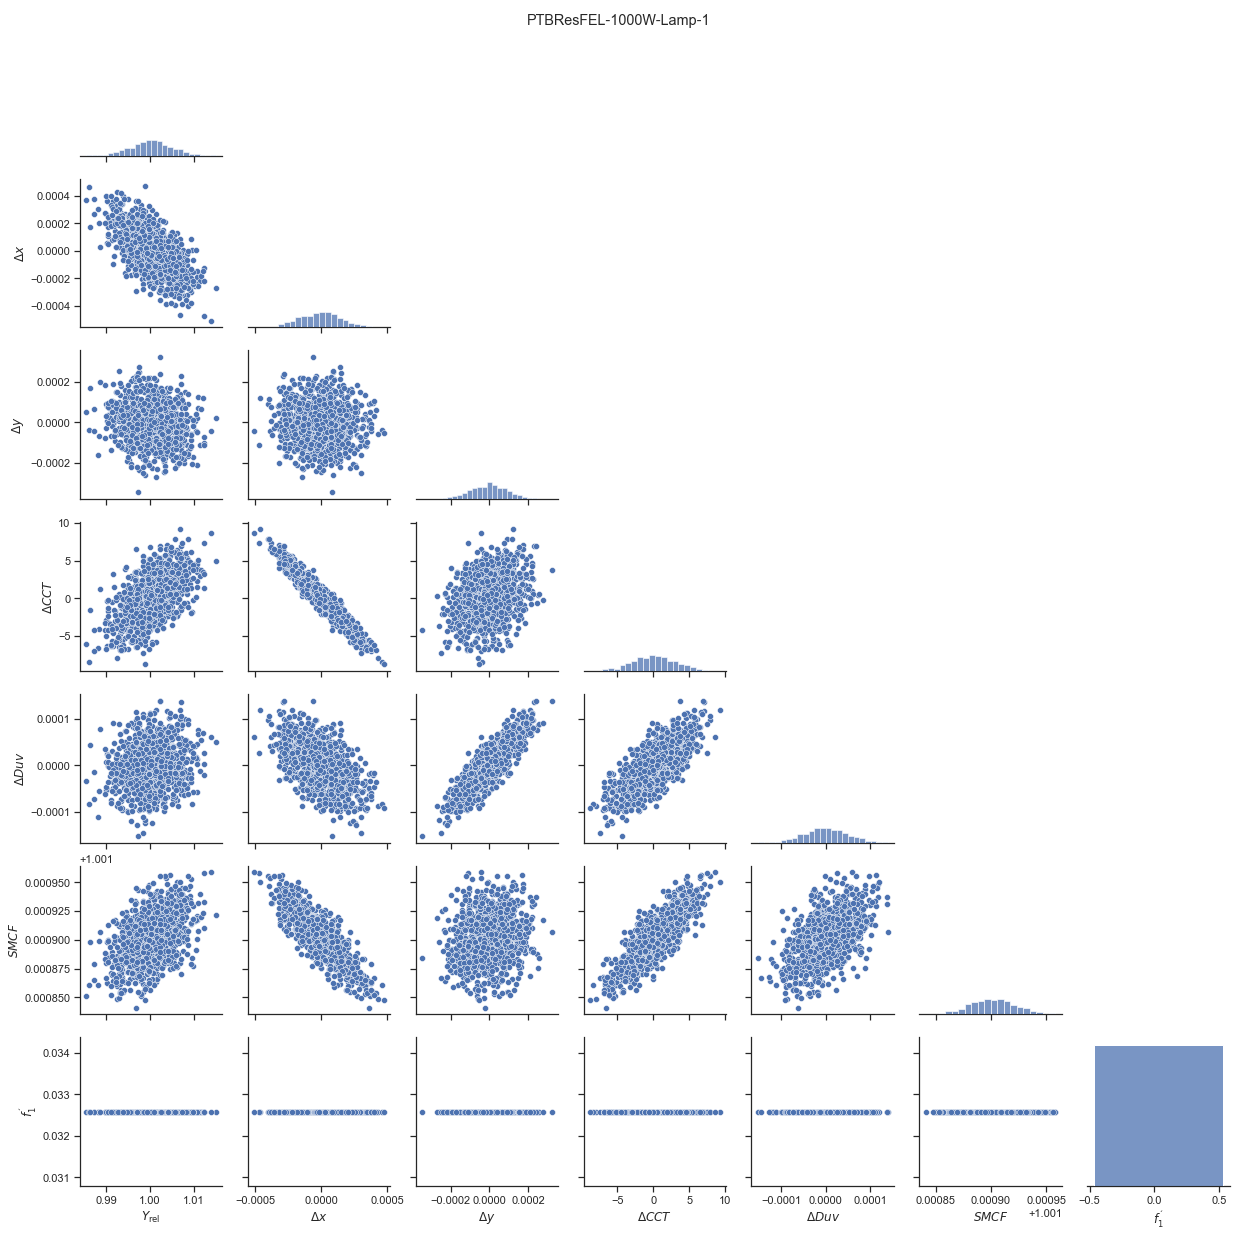

Input_Var: Add_PTBResPhot1.xlsx
[1.0000e+00 4.3179e-01 4.0275e-01 3.0777e+03 2.0551e-04 1.0019e+00
 3.2580e-02]


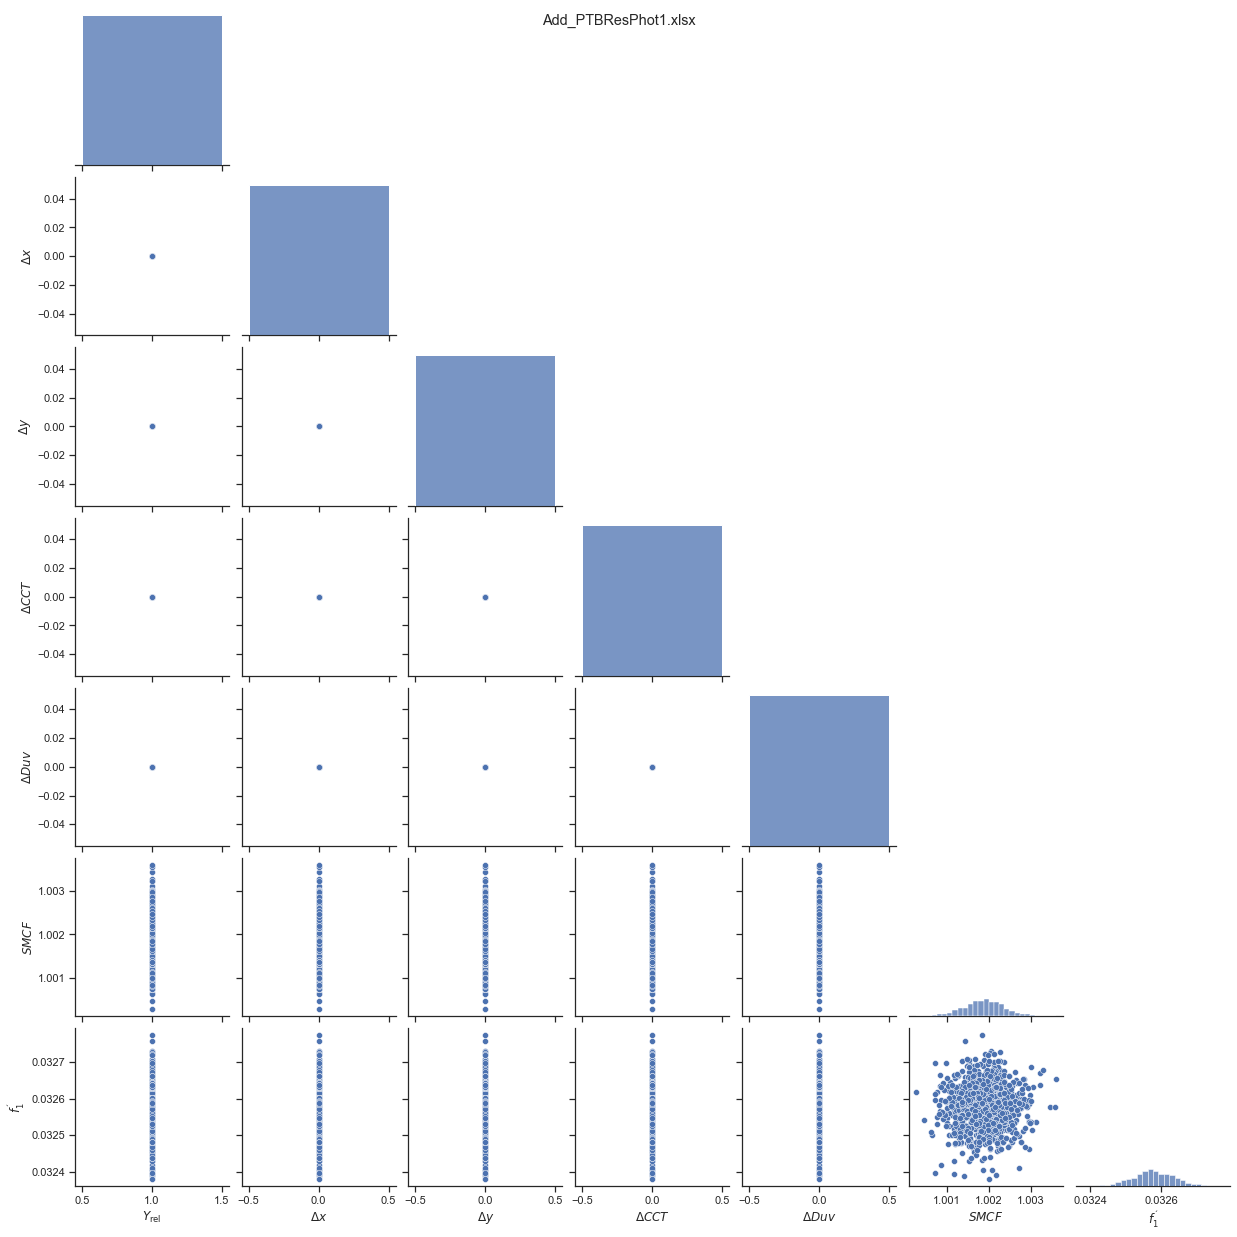

Input_Var: All
[1.0000e+00 4.3179e-01 4.0275e-01 3.0777e+03 2.0551e-04 1.0019e+00
 3.2580e-02]


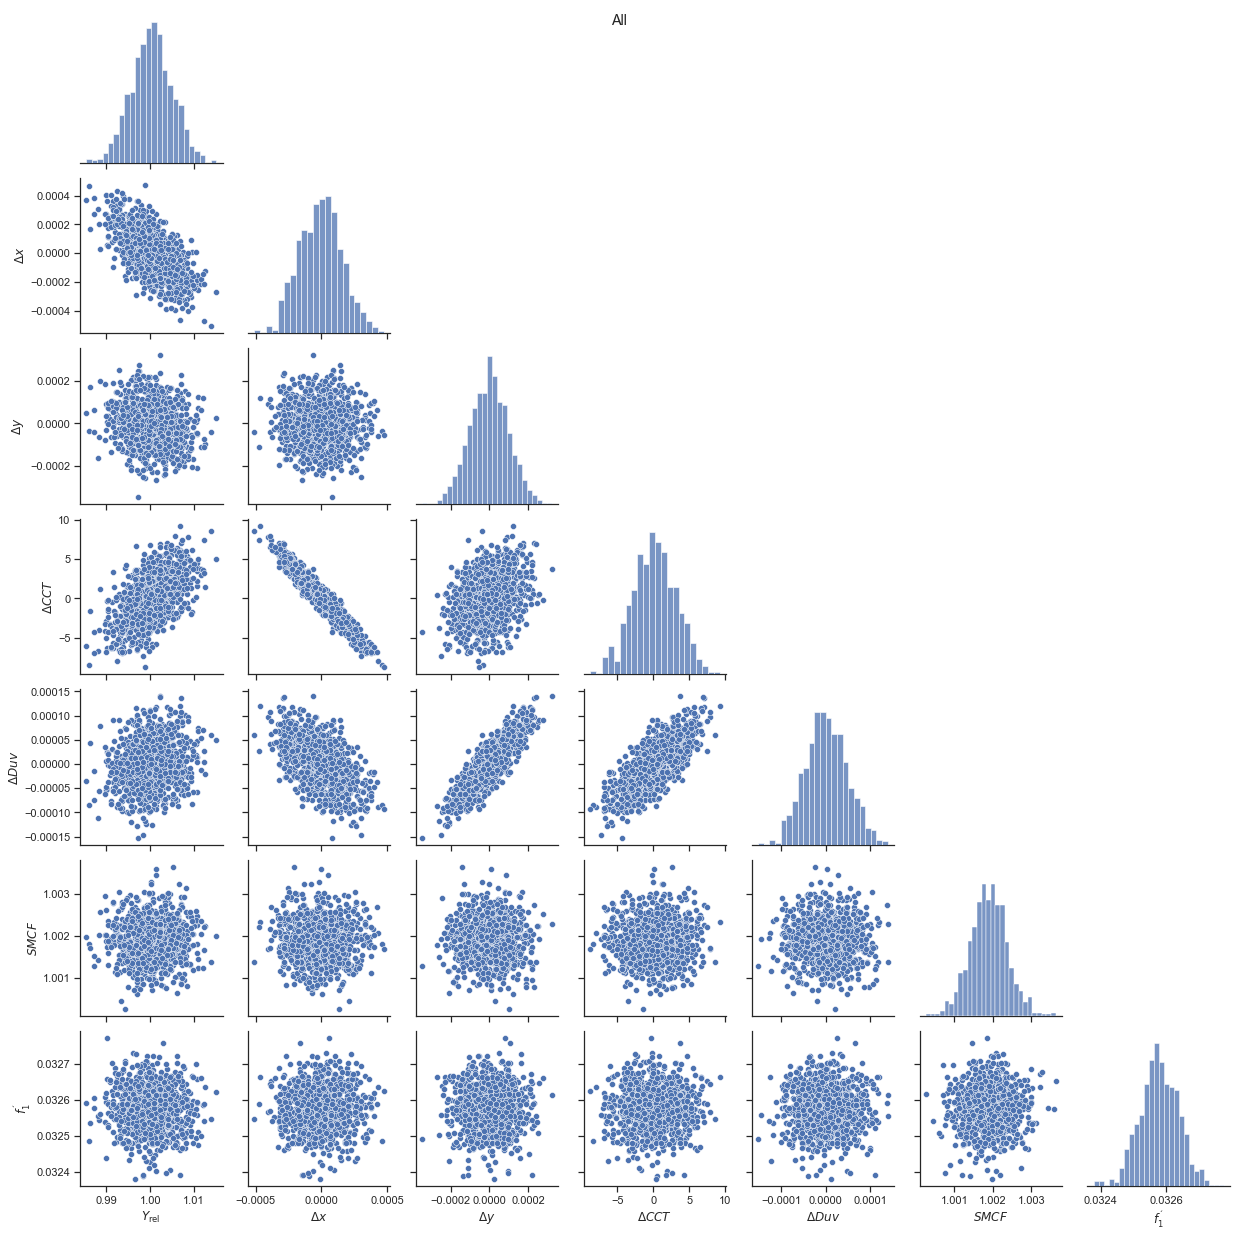

In [19]:
for i in range(len(input)+1):
    var = sim.output_var[i]
    cct = sim.output_var[i][1]
    duv = sim.output_var[i][2]
    smcf = sim.output_var[i][3]
    f1p = sim.output_var[i][4]
    print('Input_Var:', get_name(i))
    seaborn_plot_result_gen(np.vstack((var[0].val.T, cct.val.T, duv.val.T, smcf.val.T, f1p.val.T)), display=['r','d','d','d','d', 'n','n'], dim=7, column_str=column_str_MC, title=get_name(i))
    save_fig(out_dir, 'Observation_YxyCCTDuvf1p_' + get_name(i))